In [1]:
# !pip install git+https://github.com/niniack/koopmann.git@moss -qq

Imports

In [2]:
import math
import os
from collections import OrderedDict
from pathlib import Path

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import torch
from gph import ripser_parallel
from matplotlib import gridspec
from matplotlib.cm import tab10
from plotly.subplots import make_subplots
from rich import print as rprint
from rich.table import Table
from safetensors import safe_open
from scipy.spatial import procrustes
from sklearn.decomposition import PCA
from torch import is_tensor, nn
from torch.linalg import matrix_power, pinv
from torch.utils.data import DataLoader
from torcheval.metrics import MulticlassAccuracy
from tqdm import tqdm

from koopmann.aesthetics import kill_axes, kill_ticks
from koopmann.data import DatasetConfig, get_dataset_class
from koopmann.models import (
    ExponentialKoopmanAutencoder,
    KoopmanAutoencoder,
    LowRankKoopmanAutoencoder,
    ResMLP,
)
from koopmann.utils import get_device

Setup

In [3]:
file_dir = "/scratch/nsa325/koopmann_model_saves"
data_root = "/scratch/nsa325/datasets/"
device = get_device()

# Useful Methods

Utilities

In [4]:
def load_model(file_dir: str, model_name: str) -> tuple:
    """Load MLP."""
    # Original model path
    model_file_path = f"{file_dir}/{model_name}.safetensors"
    model, model_metadata = ResMLP.load_model(file_path=model_file_path)
    model.eval()
    return model, model_metadata


def load_autoencoder(file_dir: str, ae_name: str):
    # Autoenoder path in work dir
    ae_file_path = f"{file_dir}/{ae_name}.safetensors"

    # Choose model based on flag
    if "standard" in ae_name:
        AutoencoderClass = KoopmanAutoencoder
    elif "lowrank" in ae_name:
        AutoencoderClass = LowRankKoopmanAutoencoder
    elif "exponential" in ae_name:
        AutoencoderClass = ExponentialKoopmanAutencoder

    autoencoder, ae_metadata = AutoencoderClass.load_model(file_path=ae_file_path)
    _ = autoencoder.eval()

    return autoencoder, ae_metadata


def compute_model_accuracy(
    model: nn.Module,
    dataloader: DataLoader,
    device,
) -> torch.Tensor:
    """Computes the classification accuracy of a model on a given dataset."""
    model.eval()
    metric = MulticlassAccuracy()

    for batch in dataloader:
        input, target = batch
        input, target = input.to(device), target.to(device)
        output = model(input)  # Avoid explicit `forward()` call; use `model()`
        metric.update(output, target.squeeze())  # Ensure target shape compatibility

    return metric.compute()


def plot_representations(processed_act_dict, dataset, n_cols):
    # Data
    keys = list(processed_act_dict.keys())
    labels = [str(t) for t in dataset.labels]
    classes = sorted(set(labels))

    # Colors
    if dataset.name() == "YinYangDataset":
        palette = ["#fc9918", "#a779aa", "#4c3191"]  # yinyang palette
    else:
        palette = list(mcolors.TABLEAU_COLORS.values())

    colors = [palette[classes.index(cat) % len(palette)] for cat in labels]

    # Create grid of plots
    n_rows = math.ceil(len(keys) / n_cols)
    fig = plt.figure(figsize=(5 * n_cols, 5 * n_rows), dpi=300)
    gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, wspace=-0.3, hspace=0.0)
    gs.update(left=0, right=1, top=1, bottom=0)

    # Create plots
    for i, key in enumerate(keys):
        # Plot
        coords = processed_act_dict[key].cpu().numpy()
        ax = fig.add_subplot(gs[i // n_cols, i % n_cols], projection="3d")
        ax.scatter(
            coords[:, 0], coords[:, 1], coords[:, 2], s=40, c=colors, alpha=0.7, edgecolors="none"
        )
        ax.text2D(0.5, 0.05, f"L{key}", fontsize=24, ha="center", transform=ax.transAxes)

        # Clean appearance
        kill_ticks(ax)
        kill_axes(ax)
        ax.margins(0, 0, 0)  # Remove any internal margins

        # Set consistent view angle
        ax.view_init(elev=-20, azim=-50)
        ax.set_box_aspect([1, 1, 1], zoom=1.2)

Preprocessing

In [5]:
def build_acts_dict(data_train_loader, model, only_first_last, device):
    model.eval()

    original_act_dict = OrderedDict()
    for inputs, _ in data_train_loader:
        inputs = inputs.to(device)

        # Forward
        with torch.no_grad():
            _ = model(inputs)

        # Get acts
        batch_act_dict = model.get_forward_activations()
        batch_act_dict.popitem()  # Pop the last one

        # Build dictionary
        if only_first_last:
            keys = list(batch_act_dict.keys())
            first, last = keys[0], keys[-1]
            temp = set(keys) - set([first, last])

            # Pop everything in the middle
            for key in temp:
                batch_act_dict.pop(key)

        # Move to CPU and concatenate
        for key, acts in batch_act_dict.items():
            acts_cpu = acts.cpu()
            if key in original_act_dict:
                original_act_dict[key] = torch.cat([original_act_dict[key], acts_cpu], dim=0)
            else:
                original_act_dict[key] = acts_cpu

    # Clear CUDA cache to ensure GPU memory is freed
    torch.cuda.empty_cache()

    # We are using up a lot of memory.
    # Does this help out the GPU?
    del batch_act_dict

    return original_act_dict


def undo_preprocessing_acts(input_tensor, preproc_dict, index, device):
    cloned_tensor = input_tensor.clone()

    ### UNDO NORMALIZING
    norm_key = f"norm_{index}"
    if norm_key in preproc_dict:
        cloned_tensor = cloned_tensor * preproc_dict[norm_key].to(device)

    ### UNDO WHITENING
    wh_eigvals_key = f"wh_eigvals_{index}"
    wh_eigvecs_key = f"wh_eigvecs_{index}"
    wh_alpha_key = f"wh_alpha_{index}"
    if wh_eigvals_key in preproc_dict:
        cloned_tensor = Processor._unwhiten(
            cloned_tensor,
            preproc_dict[wh_eigvals_key],
            preproc_dict[wh_eigvecs_key],
            preproc_dict[wh_alpha_key],
        )

    ### UNDO PROJECTION
    directions_key = f"directions_{index}"
    if directions_key in preproc_dict:
        cloned_tensor = Processor._dim_restore_svd(
            cloned_tensor, preproc_dict[directions_key].to(device)
        )

    ### UNDO SHIFT
    mean_key = f"means_{index}"
    if mean_key in preproc_dict:
        cloned_tensor = cloned_tensor + preproc_dict[mean_key].to(device)

    return cloned_tensor


def preprocess_acts(
    original_act_dict, svd_dim, whiten_alpha, device, preprocess_dict={}, skip_svd=False
):
    # Init empty dict
    processed_act_dict = OrderedDict()

    for key, curr_act in tqdm(original_act_dict.items(), desc="Processing activations"):
        ### FLATTEN
        processed_act = torch.flatten(curr_act.clone().to(device), start_dim=1)

        ### MEAN CENTERING
        mean_key = f"means_{key}"
        means = preprocess_dict.setdefault(
            mean_key, torch.mean(processed_act, dim=0, keepdim=True).contiguous()
        )

        processed_act = processed_act - means.to(device)

        ### DIMENSIONALITY REDUCTION
        if not skip_svd:
            directions_key = f"directions_{key}"
            if directions_key not in preprocess_dict:
                processed_act, directions = Processor._dim_reduce_svd(processed_act, svd_dim)
                preprocess_dict[directions_key] = directions.contiguous()
            else:
                processed_act = processed_act @ preprocess_dict[f"directions_{key}"].T.to(device)

        ### PARAMETERIZED WHITENING
        wh_eigvals_key = f"wh_eigvals_{key}"
        wh_eigvecs_key = f"wh_eigvecs_{key}"
        wh_alpha_key = f"wh_alpha_{key}"
        if wh_eigvals_key not in preprocess_dict:
            processed_act, wh_eigvals, wh_eigvecs = Processor._whiten(
                processed_act, alpha=whiten_alpha
            )
            preprocess_dict[wh_eigvals_key] = (
                wh_eigvals.contiguous() if is_tensor(wh_eigvals) else torch.empty(1)
            )
            preprocess_dict[wh_eigvecs_key] = (
                wh_eigvecs.contiguous() if is_tensor(wh_eigvals) else torch.empty(1)
            )
            preprocess_dict[wh_alpha_key] = torch.tensor(whiten_alpha)
        else:
            processed_act = Processor._whiten_with_params(
                processed_act,
                alpha=whiten_alpha,
                eigenvalues=preprocess_dict[wh_eigvals_key],
                eigenvectors=preprocess_dict[wh_eigvecs_key],
            )

        ### NORMALIZING
        norm_key = f"norm_{key}"
        norms = preprocess_dict.setdefault(
            norm_key, (torch.linalg.norm(processed_act, ord="fro") / 1_00).contiguous()
        )
        processed_act = processed_act / norms.to(device)

        ### STORE
        processed_act_dict[key] = processed_act

    ### ALIGN TO FINAL ACT
    align_idx = list(processed_act_dict.keys())[-1]
    anchor_act = processed_act_dict[align_idx]
    for key, curr_act in processed_act_dict.items():
        if key != align_idx:
            align_key = f"align_{key}"
            if align_key not in preprocess_dict:
                _, aligned_act, _, rot_matrix = Processor._orthogonal_procrustes(
                    anchor_act, curr_act, anchor="a"
                )
                preprocess_dict[align_key] = rot_matrix
            else:
                rot_matrix = preprocess_dict[align_key]
                aligned_act = curr_act @ rot_matrix
            processed_act_dict[key] = aligned_act

    return processed_act_dict


def prepare_acts(
    data_train_loader,
    model,
    device,
    svd_dim,
    whiten_alpha=1,
    preprocess=True,
    preprocess_dict=None,
    only_first_last=True,
):
    # Hook model
    model.eval().hook_model().to(device)

    # Collect all activations
    original_act_dict = build_acts_dict(data_train_loader, model, only_first_last, device)

    # Initialize preprocessing dict
    preprocess_dict = preprocess_dict or OrderedDict()

    # Carry out preprocessing
    if preprocess:
        # Preprocess and populate `preprocess_dict`
        processed_act_dict = preprocess_acts(
            original_act_dict=original_act_dict,
            svd_dim=svd_dim,
            whiten_alpha=whiten_alpha,
            preprocess_dict=preprocess_dict,
            device=device,
        )
    else:
        # Init empty
        processed_act_dict = OrderedDict()

        # Move to GPU
        for key, act in original_act_dict.items():
            original_act_dict[key] = act.to(device)

    return (original_act_dict, processed_act_dict, preprocess_dict)


class Processor:
    @staticmethod
    def _whiten(x, alpha, clip_eigs=1e-9):
        """Compute (partial) whitening transform of x. When alpha=0 it is classic ZCA whitening and
        columns of x are totally decorrelated. When alpha=1, nothing happens.

        Assumes x is already centered.
        """

        # This is a shortcut: when alpha == 1, z is identity
        if alpha == 1:
            return x, None, None

        eigenvalues, eigenvectors = torch.linalg.eigh(x.T @ x / len(x))
        eigenvalues = torch.clip(eigenvalues, min=clip_eigs, max=None)
        d = alpha + (1 - alpha) * (eigenvalues**-0.5)
        # From right to left, the transformation (1) projects x onto v, (2) divides by stdev in each
        # direction, and (3) rotates back to align with original directions in x-space (ZCA)
        z = eigenvectors @ torch.diag(d) @ eigenvectors.T
        # Think of this as (z @ x.T).T, but note z==z.T
        return x @ z, eigenvalues, eigenvectors

    @staticmethod
    def _whiten_with_params(x, alpha, eigenvalues, eigenvectors):
        """Compute (partial) whitening transform of x, given eigenvectors and eigenvalues.
        When alpha=0 it is classic ZCA whitening and columns of x are totally decorrelated.
        When alpha=1, nothing happens.

        Assumes x is already centered.
        """
        # This is a shortcut: when alpha == 1, z is identity
        if alpha == 1:
            return x

        d = alpha + (1 - alpha) * (eigenvalues**-0.5)
        z = eigenvectors @ torch.diag(d) @ eigenvectors.T
        return x @ z

    @staticmethod
    def _unwhiten(x_whitened, eigvals, eigvecs, alpha, clip_eigs=1e-9):
        """Undo the whitening transformation."""

        # This is a shortcut: when alpha == 1, z is identity
        if alpha == 1:
            return x_whitened

        # Clip eigenvalues exactly as in the whitening function
        e = torch.clip(eigvals, min=clip_eigs, max=None)

        # More numerically stable computation of the inverse scaling
        if alpha == 0:  # Handle pure whitening case separately
            d_inv = e**0.5  # Direct inverse of e**-0.5
        else:
            # Compute inverse scaling factors more precisely
            d_inv = 1.0 / (alpha + (1 - alpha) * (e**-0.5))

        # Create the inverse transformation matrix
        z_inv = eigvecs @ torch.diag(d_inv) @ eigvecs.T

        # Force symmetry to reduce numerical errors
        z_inv = (z_inv + z_inv.T) / 2.0

        # Apply the inverse transformation
        return x_whitened @ z_inv

    @staticmethod
    def _dim_reduce_svd(x, dim):
        if dim:
            # PCA to truncate -- project onto top p principal axes (no rescaling)
            # NOTE: For large matrices, standard SVD is not stable.
            with torch.no_grad():
                # _, S, Vh = torch.linalg.svd(x, full_matrices=False)
                U, S, V = torch.svd_lowrank(x, q=dim, niter=5)
                Vh = V.T

            subset = x[:1000, :]
            total_var = torch.norm(subset, p="fro") ** 2
            error_squared = torch.norm(subset - (U[:1000, :] @ torch.diag(S) @ Vh), p="fro") ** 2
            fvu = error_squared / total_var
            # logger.info(f"Dim: {dim}")
            # logger.info(f"Variance explained: {100*(1-fvu):.2f}%")

            # Fix sign ambiguity - make the component with largest magnitude positive
            for i in range(min(dim, Vh.shape[0])):
                max_idx = torch.argmax(torch.abs(Vh[i]))
                if Vh[i, max_idx] < 0:
                    Vh[i] *= -1

            # Permute
            Vh_trunc = Vh[:dim, :]
        else:
            num_features = x.shape[-1]
            Vh_trunc = torch.eye(num_features).to(x.device)

        # import numpy as np; import matplotlib.pyplot as plt; signal = (subset[0] @ Vh[:dim, :].T).cpu(); side = int(np.sqrt(signal.shape[0])); plt.figure(figsize=(8, 8)); plt.imshow(signal[:side*side].reshape(side, side)); plt.colorbar(); plt.savefig('pca_signal.png'); plt.close()
        # import numpy as np; import matplotlib.pyplot as plt; signal = (subset[0] @ Vh_permuted.T).cpu(); side = int(np.sqrt(signal.shape[0])); plt.figure(figsize=(8, 8)); plt.imshow(signal[:side*side].reshape(side, side)); plt.colorbar(); plt.savefig('pca_signal.png'); plt.close()

        # svd returns v.T, so the principal axes are in the *rows*. The following einsum is
        # equivalent to x @ vT.T[:, :p] but a bit faster because the transpose is not actually
        # performed.
        return torch.einsum("mn,pn->mp", x, Vh_trunc), Vh_trunc

    @staticmethod
    def _dim_restore_svd(x_reduced, Vh_trunc):
        """
        Undo dimensionality reduction performed by _dim_reduce_svd.
        """
        # The original dim reduction was: x_reduced = x @ Vh_trunc.T
        # To undo, we multiply by Vh_trunc (pseudo-inverse of Vh_trunc.T)
        # This is equivalent to: x_reconstructed = x_reduced @ Vh_trunc
        return torch.einsum("mp,pn->mn", x_reduced, Vh_trunc)

    @staticmethod
    def _orthogonal_procrustes(a, b, anchor="middle"):
        """Provided a and b, each matrix of size (m, p) that are already centered and scaled, solve the
        orthogonal procrustest problem (rotate a and b into a common frame that minimizes distances).

        If anchor="middle" (default) then both a and b If anchor="a", then a is left unchanged and b is
        rotated towards it If anchor="b", then b is left unchanged and a is rotated towards it

        See
        https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem

        :return: new_a, new_b the rotated versions of a and b, minimizing element-wise squared
            differences
        """
        r_a, r_b = Processor._orthogonal_procrustes_rotation(a, b, anchor)
        # Apply rotation to a if needed
        if r_a is not None:
            a = a @ r_a
        # Apply rotation to b if needed
        if r_b is not None:
            b = b @ r_b
        return a, b, r_a, r_b

    @staticmethod
    def _orthogonal_procrustes_rotation(a, b, anchor="middle"):
        """Provided a and b, each matrix of size (m, p) that are already centered and scaled, solve the
        orthogonal procrustest problem (rotate a and b into a common frame that minimizes distances).

        If anchor="middle" (default) then both a and b If anchor="a", then a is left unchanged and b is
        rotated towards it If anchor="b", then b is left unchanged and a is rotated towards it

        See
        https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem

        :return: r_a and r_b, which, when right-multiplied with a and b, gives the aligned coordinates,
            or None for each if no transform is required
        """
        with torch.no_grad():
            u, _, v = torch.linalg.svd(a.T @ b)
        # Helpful trick to see how these are related: u is the inverse of u.T, and likewise v is
        # inverse of v.T. We get to the anchor=a and anchor=b solutions by right-multiplying both
        # return values by u.T or right-multiplying both return values by v, respectively (if both
        # return values are rotated in the same way, it preserves the shape).
        if anchor == "middle":
            return u, v.T
        elif anchor == "a":
            return None, v.T @ u.T
        elif anchor == "b":
            return u @ v, None
        else:
            raise ValueError(f"Invalid 'anchor' argument: {anchor} (must be 'middle', 'a', or 'b')")

Koopman autoencoder engine

In [6]:
def koopman_intermediates(
    init_idx,
    final_idx,
    orig_act_dict,
    proc_act_dict,
    device,
    preproc_dict,
    autoencoder,
    model,
    preprocess,
    k_steps,
):
    with torch.no_grad():
        # x = orig_act_dict[init_idx]
        # y = orig_act_dict[final_idx]

        x_proj = proc_act_dict[init_idx]
        y_proj = proc_act_dict[final_idx]

        # if preprocess:
        #     x_unproj = undo_preprocessing_acts(x_proj, preproc_dict, init_idx, device)
        #     y_unproj = undo_preprocessing_acts(y_proj, preproc_dict, final_idx, device)
        # else:
        #     x_unproj = x_proj
        #     y_unproj = y_proj

        # Reconstruct first act
        x_proj_obs = autoencoder.encode(x_proj)
        x_proj_recon = autoencoder.decode(x_proj_obs)

        # Reconstruct final act
        y_proj_obs = autoencoder.encode(y_proj)
        y_proj_recon = autoencoder.decode(y_proj_obs)

        pred_proj_obs = autoencoder.koopman_forward(x_proj_obs, k_steps)
        pred_proj = autoencoder.decode(pred_proj_obs)

        if preprocess:
            pred = undo_preprocessing_acts(pred_proj, preproc_dict, final_idx, device)
            y_recon = undo_preprocessing_acts(y_proj_recon, preproc_dict, final_idx, device)
        else:
            pred = pred_proj
            y_recon = y_proj_recon

        pred = model.components[-1:](pred)

        # Return all requested variables in a dictionary
        results = {
            "x_proj": x_proj,
            "y_proj": y_proj,
            "x_proj_obs": x_proj_obs,
            "y_proj_obs": y_proj_obs,
            "pred_proj_obs": pred_proj_obs,
            "x_proj_recon": x_proj_recon,
            "y_proj_recon": y_proj_recon,
            "y_recon": y_recon,
            "pred_proj": pred_proj,
            "pred": pred,
        }

        return results


def calculate_koopman_accuracies(ae_files, ae_dir, device, loader, model, dataset, labels):
    accs = {}
    all_orig_acts = {}
    all_proc_acts = {}
    intermediates_dict = {}

    # Process each autoencoder
    for i, ae_file in enumerate(ae_files):
        # Load preprocessing and autoencoder
        preproc = {}
        with safe_open(
            f"{ae_dir}/{ae_file.stem}_preprocessing.safetensors", framework="pt", device=device
        ) as f:
            for k in f.keys():
                preproc[k] = f.get_tensor(k)

        ae, meta = load_autoencoder(ae_dir, ae_file.stem)
        seed = int(ae_file.stem[ae_file.stem.find("seed_") + 5 :])

        # Get activations and predictions
        orig_acts, proc_acts, _ = prepare_acts(
            data_train_loader=loader,
            model=model,
            device=device,
            svd_dim=meta["in_features"],
            whiten_alpha=preproc["wh_alpha_0"],
            preprocess=True,
            preprocess_dict=preproc,
            only_first_last=True,
        )

        all_orig_acts[i] = orig_acts
        all_proc_acts[i] = proc_acts

        idx_first, idx_last = list(orig_acts.keys())[0], list(orig_acts.keys())[-1]
        ae_intermediates = koopman_intermediates(
            init_idx=idx_first,
            final_idx=idx_last,
            orig_act_dict=orig_acts,
            proc_act_dict=proc_acts,
            device=device,
            preproc_dict=preproc,
            autoencoder=ae,
            model=model,
            preprocess=True,
            k_steps=meta["k_steps"],
        )
        intermediates_dict[i] = ae_intermediates

        # Calculate accuracy
        metric = MulticlassAccuracy(num_classes=dataset.out_features, average=None)
        metric.update(ae_intermediates["pred"], labels.to(torch.long))
        accs[seed] = metric.compute()

    return all_orig_acts, all_proc_acts, intermediates_dict, accs


def create_accuracy_table(accuracies, dataset_name):
    table = Table(title=f"{dataset_name} KAE Accuracies")
    table.add_column("Seed")
    table.add_column("Per-Class Accuracy")
    table.add_column("Overall Accuracy")

    # Format accuracy data
    seeds = list(accuracies.keys())
    values = np.array([v.numpy() for v in accuracies.values()])
    overall = np.array([v.mean().item() for v in accuracies.values()])
    fmt = lambda arr: "[" + ", ".join([f"{x*100:.2f}%" for x in arr]) + "]"

    # Add rows for each seed
    for i, seed in enumerate(seeds):
        table.add_row(
            str(seed), fmt(values[i]), f"{overall[i]*100:.2f}%", end_section=(i == len(seeds) - 1)
        )

    # Add summary statistics
    table.add_row("Mean", fmt(values.mean(axis=0)), f"{overall.mean()*100:.2f}%", style="bold")
    table.add_row(
        "Std", fmt(values.std(axis=0)), f"{overall.std()*100:.2f}%", style="bold", end_section=True
    )

    return table

Topology

In [7]:
def get_betti_numbers(data, max_dim, eps):
    result = ripser_parallel(data, maxdim=max_dim, thresh=eps, n_threads=-1)
    betti_numbers = {}

    for dim in range(max_dim + 1):
        dgm = result["dgms"][dim]
        count = 0
        for birth, death in dgm:
            if birth <= eps and (death > eps or np.isinf(death)):
                count += 1
        betti_numbers[dim] = count

    return betti_numbers


def plot_betti_and_pca(betti_per_run, labels, preds, subset_size=1000):
    # Create figure with GridSpec
    fig = plt.figure(figsize=(15, 6))
    gs = gridspec.GridSpec(2, 4, figure=fig, wspace=0.1, hspace=0.3)
    gs.update(left=0, right=0.8, top=1, bottom=0)

    # Helper function for common plotting pattern
    def plot_annotated_betti_numbers(ax, x, y, fill_data=None):
        ax.plot(x, y, linewidth=3, color="#4c3191")
        ax.set_xticks(x)
        for xi, yi in zip(x, y):
            ax.annotate(
                f"{yi:.0f}",
                (xi, yi),
                xytext=(3, 5.5),
                textcoords="offset points",
                fontsize=12,
                va="center",
            )
        if fill_data:
            ax.fill_between(x, fill_data[0], fill_data[1], alpha=0.2, color="#4c3191")

    # Process KAE data
    def arrange_data(betti_per_run, dim):
        runs = list(run[dim] for run in betti_per_run.values())
        if idx is None:
            idx_values = range(len(runs[0]))
        else:
            idx_values = idx
        data = np.array([[run[j] for run in runs] for j in idx_values]).T
        min_vals, mean_vals, max_vals = [f(data, axis=0) for f in (np.min, np.mean, np.max)]
        return min_vals, mean_vals, max_vals

    ##### BETTI NUMBERS
    # KAE data subplot
    idx_values = range(len(next(iter(betti_per_run.values()))[0]))

    b0_min, b0_mean, b0_max = arrange_data(betti_per_run=betti_per_run, dim=0)
    ax2 = fig.add_subplot(gs[0, :])
    plot_annotated_betti_numbers(ax2, idx_values, b0_mean, fill_data=(b0_min, b0_max))
    ax2.set_title("KAE Betti Numbers")
    ax2.set_xlabel("Iteration")
    ax2.set_yscale("log")
    ax2.set_ylabel(f"β0 Estimate")
    sns.despine(ax=ax2)

    ##### SCATTER
    labels_subset = [str(t.item()) for t in labels[:subset_size]]
    classes = sorted(set(labels_subset))

    palette = [tab10(i) for i in range(10)]  # Get first 10 colors from Tableau10
    colors = [palette[classes.index(label) % 10] for label in labels_subset]

    iters = [0, 3, 6, 10]
    subset_preds = [preds[t] for t in iters]
    pca = PCA(n_components=3)
    reference = pca.fit_transform(subset_preds[0][:subset_size])

    for i, pred in enumerate(subset_preds):
        red_coords = pca.fit_transform(pred[:subset_size])
        _, red_coords, _ = procrustes(reference, red_coords)
        ax = fig.add_subplot(gs[1, i], projection="3d")
        ax.scatter(
            red_coords[:, 0],
            red_coords[:, 1],
            red_coords[:, 2],
            s=30,
            alpha=0.7,
            edgecolors="none",
            c=colors,
        )
        ax.text2D(
            0,
            0.9,
            f"Iter. {iters[i]}",
            fontsize=14,
            ha="center",
            transform=ax.transAxes,
        )
        kill_ticks(ax)
        kill_axes(ax)
        ax.margins(0, 0, 0)
        ax.view_init(elev=-30, azim=90)
        ax.set_box_aspect([1, 1, 1], zoom=1.4)

    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update(
        {
            "axes.labelsize": 14,
            "axes.titlesize": 16,
            "xtick.labelsize": 12,
            "ytick.labelsize": 12,
        }
    )


# Yin-Yang Task

### Yin-Yang Models

In [8]:
yinyang_model_name = "resmlp5_yinyang"

yinyang_model, yinyang_model_metadata = load_model(file_dir, yinyang_model_name)
yinyang_model.hook_model().eval().to(device)
rprint("MLP Metadata: ", yinyang_model_metadata)

yinyang_ae_file_dir = "/scratch/nsa325/koopmann_model_saves/yinyang"
yinyang_ae_files = sorted(os.listdir(yinyang_ae_file_dir))
yinyang_ae_files = [
    Path(file)
    for file in yinyang_ae_files
    if ("autoencoder" in file and "preprocessing" not in file)
]

MLP Metadata: 
{
    'batchnorm': True,
    'bias': True,
    'created_at': '2025-05-07T14:35:24.868647',
    'dataset': 'YinYangDataset',
    'hidden_config': [10, 10, 10, 10, 10],
    'in_features': 2,
    'model_class': 'ResMLP',
    'nonlinearity': 'relu',
    'out_features': 3,
    'stochastic_depth_mode': 'batch',
    'stochastic_depth_prob': 0.0
}

### Yin-Yang Data

In [9]:
# Dataset config
yinyang_dataset_config = DatasetConfig(
    dataset_name=yinyang_model_metadata["dataset"],
    num_samples=3_000,
    split="test",
    seed=42,
)
DatasetClass = get_dataset_class(name=yinyang_dataset_config.dataset_name)
yinyang_dataset = DatasetClass(config=yinyang_dataset_config, root=data_root)
yinyang_labels = yinyang_dataset.labels.squeeze()

yinyang_dataloader = DataLoader(yinyang_dataset, batch_size=512)

### Yin-Yang Neural Representations

Yin-Yang Model Accuracy: 0.9936666488647461

Processing activations: 100%|██████████| 6/6 [00:00<00:00, 44.92it/s]


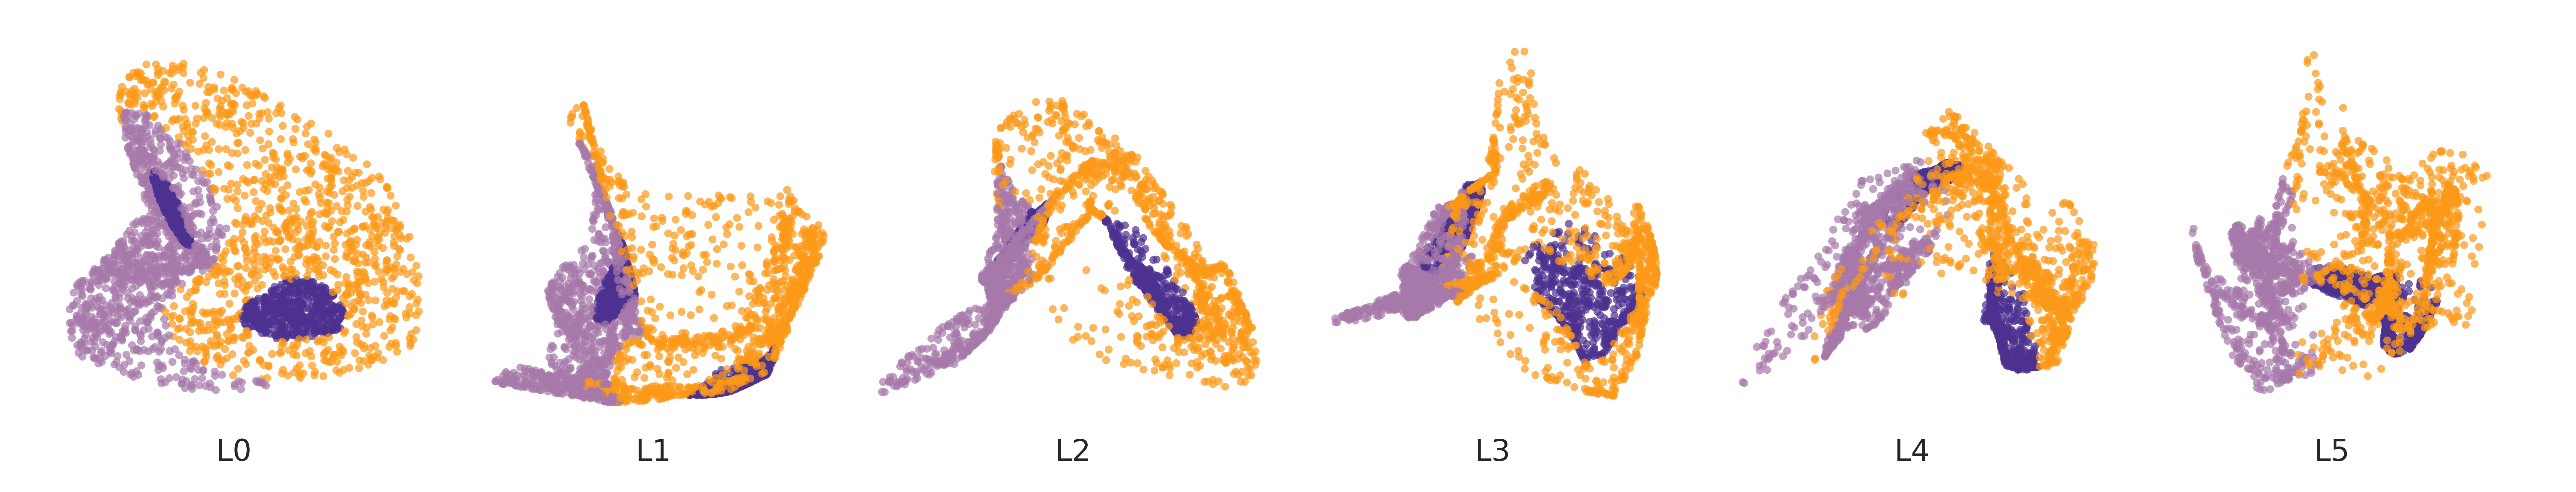

In [10]:
rprint(
    f"Yin-Yang Model Accuracy: {compute_model_accuracy(yinyang_model, yinyang_dataloader, device)}"
)

# Collect and preprocess activations
yinyang_original_act_dict = build_acts_dict(
    data_train_loader=yinyang_dataloader, model=yinyang_model, only_first_last=False, device=device
)
yinyang_processed_act_dict = preprocess_acts(
    original_act_dict=yinyang_original_act_dict,
    svd_dim=3,
    whiten_alpha=1,
    device=device,
    preprocess_dict={},
)

plot_representations(
    processed_act_dict=yinyang_processed_act_dict, dataset=yinyang_dataset, n_cols=6
)

### Yin-Yang KAE Accuracies

In [11]:
yinyang_ae_orig_dict, yinyang_ae_proc_dict, yinyang_ae_intermediates, yinyang_ae_accuracies = (
    calculate_koopman_accuracies(
        ae_files=yinyang_ae_files,
        ae_dir=yinyang_ae_file_dir,
        device=device,
        loader=yinyang_dataloader,
        model=yinyang_model,
        dataset=yinyang_dataset,
        labels=yinyang_labels,
    )
)
create_accuracy_table(accuracies=yinyang_ae_accuracies, dataset_name=yinyang_dataset.name())


Processing activations: 100%|██████████| 2/2 [00:00<00:00, 143.56it/s]
/scratch/nsa325/.cache/pypoetry/virtualenvs/koopmann-J7sjGzNf-py3.11/lib/python3.11/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:230.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")
Processing activations: 100%|██████████| 2/2 [00:00<00:00, 325.18it/s]


             YinYangDataset KAE Accuracies             
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Seed ┃ Per-Class Accuracy        ┃ Overall Accuracy ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ 21   │ [98.29%, 98.64%, 100.00%] │ 98.98%           │
│ 365  │ [97.89%, 98.34%, 100.00%] │ 98.75%           │
│ 53   │ [97.99%, 98.73%, 99.90%]  │ 98.87%           │
│ 74   │ [98.39%, 98.93%, 100.00%] │ 99.11%           │
│ 99   │ [97.49%, 98.64%, 99.80%]  │ 98.64%           │
├──────┼───────────────────────────┼──────────────────┤
│ Mean │ [98.01%, 98.66%, 99.94%]  │ 98.87%           │
│ Std  │ [0.32%, 0.19%, 0.08%]     │ 0.16%            │
└──────┴───────────────────────────┴──────────────────┘

# MNIST Task

### MNIST Models

In [12]:
mnist_model_name = "resmlp_mnist"
mnist_model, mnist_model_metadata = load_model(file_dir, mnist_model_name)
mnist_model.hook_model().eval().to(device)
rprint("MLP Metadata: ", mnist_model_metadata)

mnist_ae_file_dir = "/scratch/nsa325/koopmann_model_saves/mnist"
mnist_ae_files = sorted(os.listdir(mnist_ae_file_dir))
mnist_ae_files = [
    Path(file) for file in mnist_ae_files if ("autoencoder" in file and "preprocessing" not in file)
]
mnist_ae_list = []
mnist_ae_preproc_list = []
for mnist_ae_file in mnist_ae_files:
    mnist_ae, mnist_ae_metadata = load_autoencoder(mnist_ae_file_dir, mnist_ae_file.stem)
    mnist_ae_list.append(mnist_ae.eval().to(device))

    preproc_dict = {}
    with safe_open(
        f"{mnist_ae_file_dir}/{mnist_ae_file.stem}_preprocessing.safetensors",
        framework="pt",
        device=device,
    ) as f:
        for k in f.keys():
            preproc_dict[k] = f.get_tensor(k)

    mnist_ae_preproc_list.append(preproc_dict)

MLP Metadata: 
{
    'batchnorm': True,
    'bias': True,
    'created_at': '2025-04-09T02:41:58.432513',
    'dataset': 'MNISTDataset',
    'hidden_config': [784, 784, 784, 784],
    'in_features': 784,
    'model_class': 'ResMLP',
    'nonlinearity': 'relu',
    'out_features': 10,
    'stochastic_depth_mode': 'batch',
    'stochastic_depth_prob': 0.0
}

### MNIST Data

In [13]:
# Dataset config
mnist_dataset_config = DatasetConfig(
    dataset_name=mnist_model_metadata["dataset"],
    num_samples=10_000,
    split="test",
    seed=42,
)
DatasetClass = get_dataset_class(name=mnist_dataset_config.dataset_name)
mnist_dataset = DatasetClass(config=mnist_dataset_config, root=data_root)
mnist_labels = mnist_dataset.labels.squeeze()

mnist_dataloader = DataLoader(mnist_dataset, batch_size=2_048)

### MNIST Neural Representations

MNIST Model Accuracy: 0.9904000163078308

Processing activations: 100%|██████████| 5/5 [00:00<00:00, 44.80it/s]


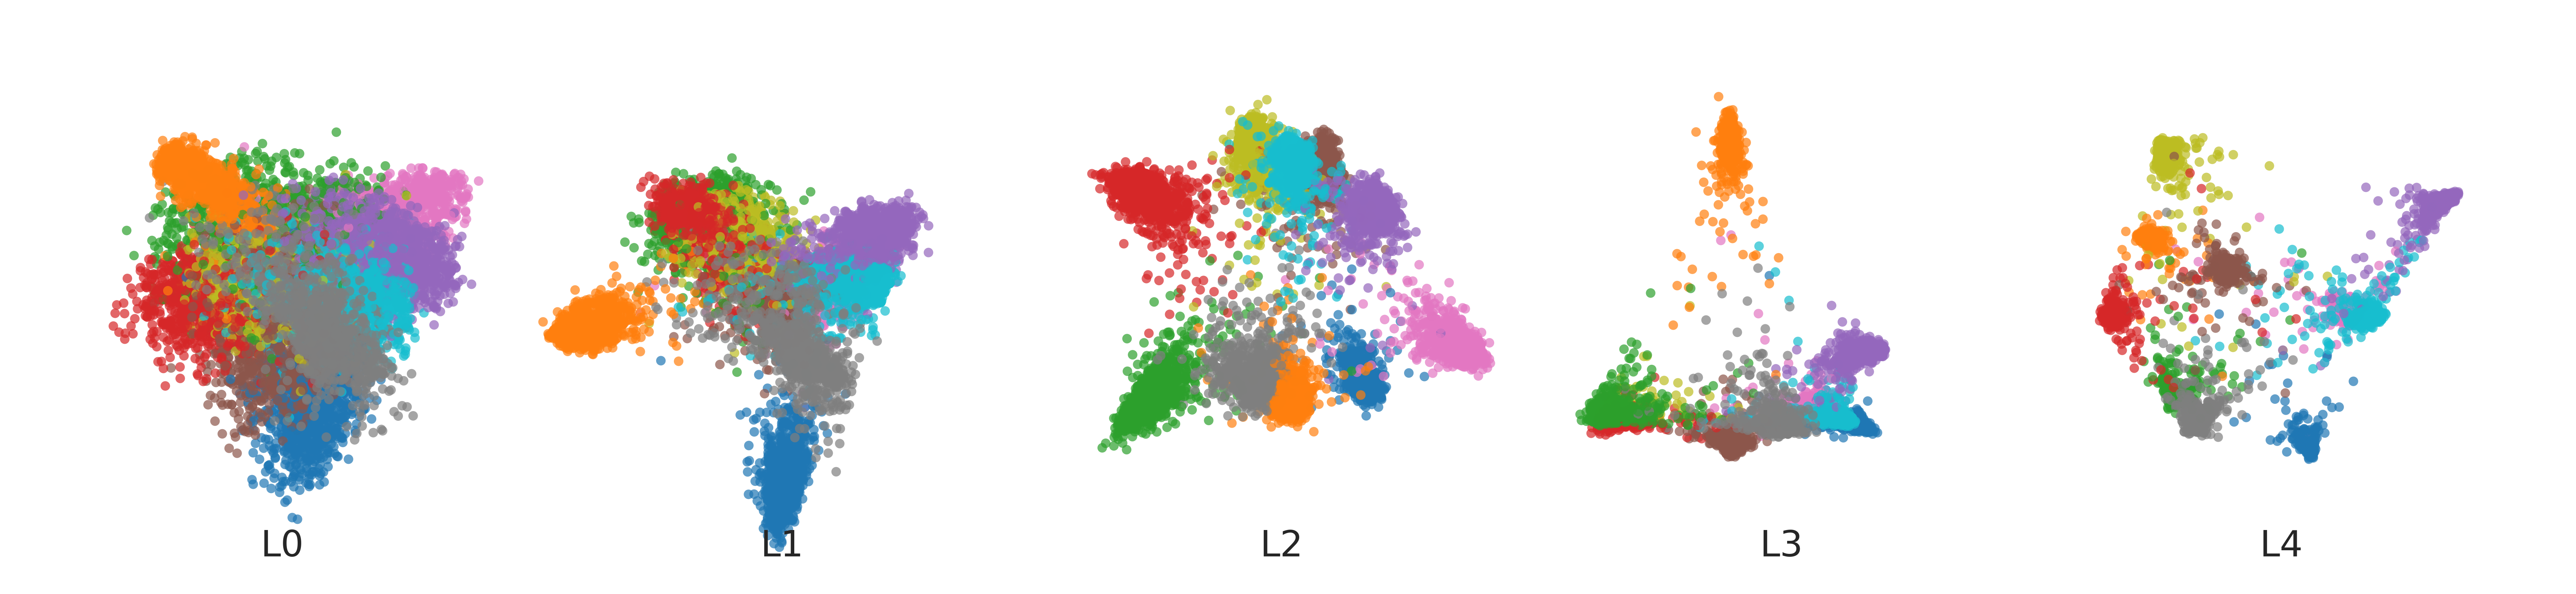

In [14]:
rprint(f"MNIST Model Accuracy: {compute_model_accuracy(mnist_model, mnist_dataloader, device)}")

# Collect and preprocess activations
mnist_original_act_dict = build_acts_dict(
    data_train_loader=mnist_dataloader, model=mnist_model, only_first_last=False, device=device
)
mnist_processed_act_dict = preprocess_acts(
    original_act_dict=mnist_original_act_dict,
    svd_dim=3,
    whiten_alpha=1,
    device=device,
    preprocess_dict={},
)

plot_representations(processed_act_dict=mnist_processed_act_dict, dataset=mnist_dataset, n_cols=5)

### MNIST KAE Accuracies

In [15]:
mnist_ae_orig_dict, mnist_ae_proc_dict, mnist_ae_intermediates, mnist_ae_accuracies = (
    calculate_koopman_accuracies(
        ae_files=mnist_ae_files,
        ae_dir=mnist_ae_file_dir,
        device=device,
        loader=mnist_dataloader,
        model=mnist_model,
        dataset=mnist_dataset,
        labels=mnist_labels,
    )
)
create_accuracy_table(accuracies=mnist_ae_accuracies, dataset_name=mnist_dataset.name())


Processing activations: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s]


                                         MNISTDataset KAE Accuracies                                          
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Seed ┃ Per-Class Accuracy                                                               ┃ Overall Accuracy ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ 21   │ [99.39%, 99.30%, 98.84%, 98.61%, 98.37%, 98.88%, 98.43%, 97.96%, 98.67%, 97.62%] │ 98.61%           │
│ 365  │ [99.39%, 99.21%, 98.64%, 98.32%, 98.27%, 98.99%, 98.64%, 98.05%, 98.15%, 97.42%] │ 98.51%           │
│ 53   │ [99.39%, 99.21%, 98.84%, 98.42%, 98.27%, 98.32%, 98.54%, 98.35%, 98.46%, 97.52%] │ 98.53%           │
│ 74   │ [99.39%, 99.21%, 99.03%, 98.32%, 98.17%, 98.32%, 98.43%, 97.86%, 98.36%, 97.72%] │ 98.48%           │
│ 99   │ [99.39%, 99.21%, 98.93%, 98.22%, 98.37%, 98.43%, 98.85%, 97.86%, 98.36%, 97.82%] │ 98.54%           │
├──────┼──────────────────────────────────────────────────────────────────────────────────┼──────────────────┤
│ Mean │ [99.39%, 99.22%, 98.86%, 98.38%, 98.29%, 98.59%, 98.58%, 98.02%, 98.40%, 97.62%] │ 98.53%           │
│ Std  │ [0.00%, 0.04%, 0.13%, 0.13%, 0.08%, 0.29%, 0.16%, 0.18%, 0.17%, 0.14%]           │ 0.04%            │
└──────┴──────────────────────────────────────────────────────────────────────────────────┴──────────────────┘

### MNIST Topology

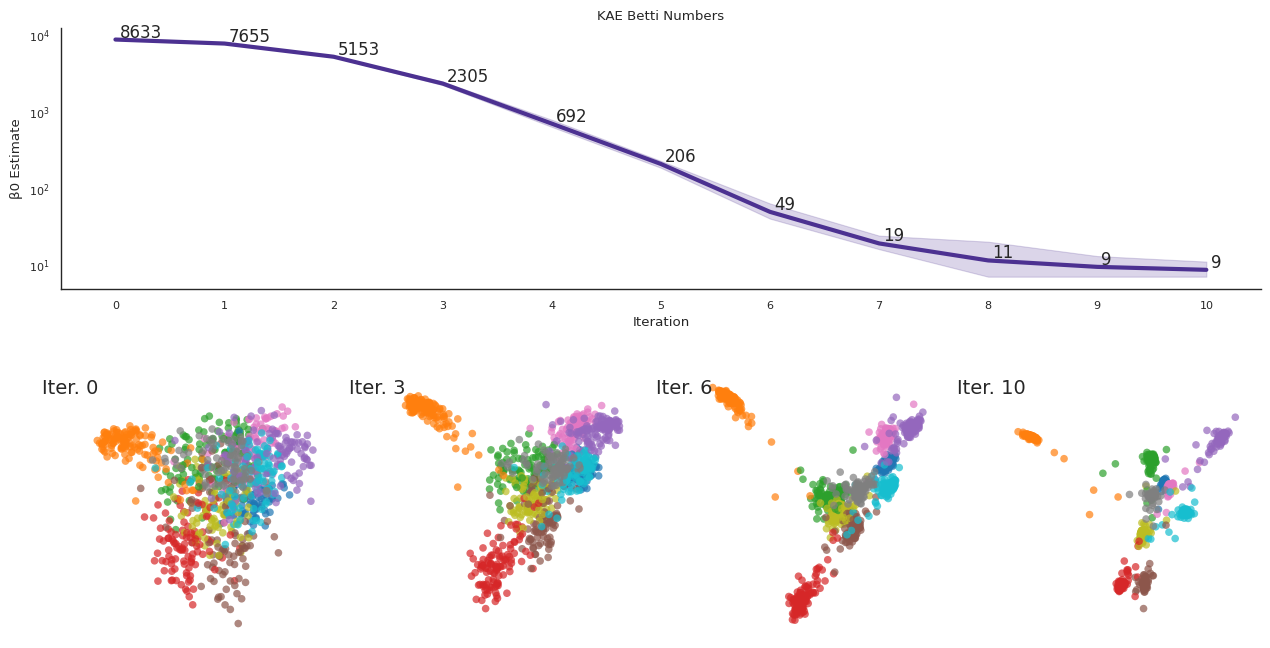

In [16]:
MAX_DIM = 0
EPS = 0.14
betti_per_run = {}  # Dictionary to store all Betti numbers
preds_per_run = {}
with torch.no_grad():
    for i, (autoencoder, proc_act_dict) in enumerate(
        zip(mnist_ae_list, list(mnist_ae_proc_dict.values()))
    ):
        preds = autoencoder.forward(
            proc_act_dict[0], intermediate=True, k=mnist_ae_metadata["k_steps"]
        ).predictions
        idx = range(len(preds))

        preds_per_run[i] = preds

        # Initialize dictionary for this run if it doesn't exist
        if i not in betti_per_run:
            betti_per_run[i] = {dim: [] for dim in range(MAX_DIM + 1)}

        # Compute Betti numbers for all intermediates
        for j, pred in enumerate(preds):
            betti_numbers = get_betti_numbers(data=pred, max_dim=MAX_DIM, eps=EPS)

            for dim in range(MAX_DIM + 1):
                betti_per_run[i][dim].append(betti_numbers[dim])

plot_betti_and_pca(betti_per_run=betti_per_run, labels=mnist_labels, preds=preds_per_run[0])

### MNIST Editing

In [17]:
def get_clean_indices(all_inputs, harmful_inputs, tolerance=1e-3):
    """
    Given all_= inputs (A) and harmful inputs (B), where size(B) < size(A),
    filter all inputs and find closest clean input to each harmful input
    """
    # Calculate distances between all inputs and harmful inputs
    distances = torch.cdist(all_inputs, harmful_inputs)

    # Identify potentially harmful inputs
    min_distances, closest_indices = torch.min(distances, dim=0)
    harmful_indices = closest_indices[min_distances <= tolerance]

    # Get non-harmful input indices
    all_indices = torch.arange(len(all_inputs))
    non_harmful_indices = torch.tensor([i for i in all_indices if i not in harmful_indices.cpu()])

    # Find the nearest clean input for each harmful input
    clean_distances = distances[non_harmful_indices]
    _, closest_clean_rel_indices = torch.min(clean_distances, dim=0)
    closest_clean_indices = non_harmful_indices[closest_clean_rel_indices]

    return non_harmful_indices, closest_clean_indices


def edit_operator(original_operator, clean_inputs, harmful_inputs, closest_clean_target, reg=0.1):
    # Preservation component (clean data preservation)
    C0 = clean_inputs.T @ clean_inputs
    C0_inv = torch.linalg.inv(C0 + reg * torch.eye(C0.shape[0]))

    # Memorization component (harmful outputs correction)
    R = closest_clean_target - harmful_inputs @ original_operator

    # Calculate intermediate matrices
    H_trans = harmful_inputs.T
    D = harmful_inputs @ C0_inv @ H_trans
    D_inv = torch.linalg.inv(D + reg * torch.eye(D.shape[0]))

    # Compute correction term and update operator
    delta = C0_inv @ H_trans @ D_inv @ R
    edited_operator = original_operator + delta

    return edited_operator


def plot_operator_comparison(pred_proj_obs, new_pred_proj_obs, labels, subset_size=2_000):
    # PCA dimensionality reduction
    og_reduced = PCA(n_components=3).fit_transform(pred_proj_obs)
    new_reduced = PCA(n_components=3).fit_transform(new_pred_proj_obs)
    _, new_reduced, _ = procrustes(og_reduced, new_reduced)

    # Ensure subset_size doesn't exceed available data
    sub = min(subset_size, len(og_reduced))
    labels_subset = [str(label.item()) for label in labels[:sub]]

    # Create subplot figure
    fig = make_subplots(
        rows=1,
        cols=2,
        specs=[[{"type": "scene"}, {"type": "scene"}]],
        subplot_titles=["Before Edit", "After Edit"],
    )

    # Create traces with marker outlines
    for i, (data, row, col) in enumerate([(og_reduced, 1, 1), (new_reduced, 1, 2)]):
        for label in set(labels_subset):
            mask = [l == label for l in labels_subset]
            fig.add_trace(
                go.Scatter3d(
                    x=data[:sub][mask, 0],
                    y=data[:sub][mask, 1],
                    z=data[:sub][mask, 2],
                    mode="markers",
                    marker=dict(
                        size=3, opacity=0.8, line=dict(width=0.01, color="rgba(0, 0, 0, 1)")
                    ),
                    showlegend=False,
                ),
                row=row,
                col=col,
            )

    # Update layout
    fig.update_layout(showlegend=False, height=500, width=1000)

    return fig

Work with the training dataset to get new operator

In [18]:
# Get MNIST train data
train_mnist_dataset_config = DatasetConfig(
    dataset_name=mnist_model_metadata["dataset"],
    num_samples=60_000,
    split="train",
    seed=42,
)
DatasetClass = get_dataset_class(name=train_mnist_dataset_config.dataset_name)
train_mnist_dataset = DatasetClass(config=train_mnist_dataset_config, root=data_root)
train_mnist_labels = train_mnist_dataset.labels.squeeze()
train_mnist_dataloader = DataLoader(train_mnist_dataset, batch_size=5_000, shuffle=False)


# Get intermediates
with torch.no_grad():
    train_mnist_ae_orig_dict, train_mnist_ae_proc_dict, train_mnist_ae_intermediates, _ = (
        calculate_koopman_accuracies(
            ae_files=mnist_ae_files,
            ae_dir=mnist_ae_file_dir,
            device=device,
            loader=train_mnist_dataloader,
            model=mnist_model,
            dataset=train_mnist_dataset,
            labels=train_mnist_labels,
        )
    )


Processing activations: 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


In [19]:
ae_idx = 0
x_proj = train_mnist_ae_intermediates[ae_idx]["x_proj"]
x_proj_obs = train_mnist_ae_intermediates[ae_idx]["x_proj_obs"]
y_proj = train_mnist_ae_intermediates[ae_idx]["y_proj"]
y_proj_obs = train_mnist_ae_intermediates[ae_idx]["y_proj_obs"]
pred_proj = train_mnist_ae_intermediates[ae_idx]["pred_proj"]
pred_proj_obs = train_mnist_ae_intermediates[ae_idx]["pred_proj_obs"]
pred = train_mnist_ae_intermediates[ae_idx]["pred"]


# Find indices for target class
target_class = 4
(subset_idx,) = torch.where(train_mnist_labels == target_class)

# Get subsets
subset_labels = train_mnist_labels[subset_idx]
subset_x_proj = x_proj[subset_idx]
subset_x_proj_obs = x_proj_obs[subset_idx]
subset_y_proj = y_proj[subset_idx]
subset_y_proj_obs = y_proj_obs[subset_idx]

# Get harmful outputs
autoencoder = mnist_ae_list[ae_idx]
preproc_dict = mnist_ae_preproc_list[ae_idx]
x_obs_advanced = autoencoder.koopman_forward(x_proj_obs, mnist_ae_metadata["k_steps"])
harmful_outputs = x_obs_advanced[subset_idx]


In [26]:
with torch.no_grad():
    # Invert operator
    inv_operator = matrix_power(pinv(autoencoder.koopman_weights.T), mnist_ae_metadata["k_steps"])

    # Find inputs from inverted operator
    harmful_inputs = harmful_outputs @ inv_operator

    # Get clean indices and closest clean to
    clean_inputs_idx, closest_clean_idx = get_clean_indices(x_proj_obs, harmful_inputs)
    closest_clean_target = pred_proj_obs[closest_clean_idx]

    temp = closest_clean_target.clone()
    closest_clean_target = temp[0].expand(closest_clean_target.shape)

    new_operator = edit_operator(
        original_operator=torch.linalg.matrix_power(
            autoencoder.koopman_weights.T, mnist_ae_metadata["k_steps"]
        ),
        clean_inputs=x_proj_obs[clean_inputs_idx],
        harmful_inputs=harmful_inputs,
        closest_clean_target=closest_clean_target,
    )

    new_pred_proj_obs = x_proj_obs @ new_operator
    new_pred_proj = autoencoder.decode(new_pred_proj_obs)
    new_pred = undo_preprocessing_acts(
        input_tensor=new_pred_proj,
        preproc_dict=preproc_dict,
        index=list(train_mnist_ae_proc_dict[ae_idx].keys())[-1],
        device=device,
    )

    new_pred = mnist_model.components[-1:](new_pred)

    # Per-class accuracy
    per_class_metric = MulticlassAccuracy(
        num_classes=train_mnist_dataset.out_features, average=None
    )
    per_class_metric.update(new_pred, train_mnist_labels.to(torch.long))
    print("Koopman accuracy per class:", per_class_metric.compute())

    # Overall accuracy
    overall_metric = MulticlassAccuracy(num_classes=train_mnist_dataset.out_features)
    overall_metric.update(new_pred, train_mnist_labels.to(torch.long))
    print("Overall Koopman accuracy:", overall_metric.compute())


Koopman accuracy per class: tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Overall Koopman accuracy: tensor(0.9026)
